In [ ]:
# import pandas as pd
# from category_encoders import TargetEncoder

# # Load the data
# train_data = pd.read_csv("../../Data/normalized_train.csv")
# test_data = pd.read_csv("../../Data/normalized_test.csv")

# # Define the categorical columns to encode
# categorical_cols = ['town', 'flat_type', 'flat_model']
# target_col = 'resale_price'

# # Initialize TargetEncoder
# encoder = TargetEncoder(cols=categorical_cols)

# # Fit on training data and transform both train and test
# train_data_encoded = train_data.copy()
# test_data_encoded = test_data.copy()

# train_data_encoded[categorical_cols] = encoder.fit_transform(train_data[categorical_cols], train_data[target_col])
# test_data_encoded[categorical_cols] = encoder.transform(test_data[categorical_cols])

# # Save encoded datasets (optional)
# train_data_encoded.to_csv("../../Data/target_encoded_train.csv", index=False)
# test_data_encoded.to_csv("../../Data/target_encoded_test.csv", index=False)

# # Display first few rows
# train_data_encoded.head()


import pandas as pd

# Load the data
train_data = pd.read_csv("../../Data/normalized_train.csv")
test_data = pd.read_csv("../../Data/normalized_test.csv")

# Define categorical columns and target
categorical_cols = ['town', 'flat_type', 'flat_model']
target_col = 'resale_price'

# Create a copy of the datasets
train_data_encoded = train_data.copy()
test_data_encoded = test_data.copy()

# Apply target encoding manually
for col in categorical_cols:
    mean_target = train_data.groupby(col)[target_col].mean()  # Compute mean resale price per category
    train_data_encoded[col] = train_data[col].map(mean_target)  # Replace in train set
    test_data_encoded[col] = test_data[col].map(mean_target)  # Apply to test set

# Handle missing values in test set (for unseen categories)
test_data_encoded.fillna(train_data[target_col].mean(), inplace=True)

# Save encoded datasets (optional)
train_data_encoded.to_csv("target_encoded_train.csv", index=False)
test_data_encoded.to_csv("target_encoded_test.csv", index=False)

# Display first few rows
train_data_encoded.head()


,month,year,town,town_LE,town_YISHUN,town_WOODLANDS,town_TOA PAYOH,town_TAMPINES,town_SERANGOON,town_SENGKANG,...,Secondary_within_1km,Secondary_nearest,JuniorCollege_within_1km,JuniorCollege_nearest,MixedLevel_within_1km,MixedLevel_nearest,NParks_within_1km,NParks_nearest,Sports_within_1km,Sports_nearest
0,4,2021,0.243078,0,False,False,False,False,False,False,...,1,0.001223,1,0.001000,1,0.000443,13,0.000438,0,0.001687
1,6,2021,0.345563,4,False,False,False,False,False,False,...,0,0.001718,0,0.006330,0,0.006940,13,0.000370,0,0.002311
2,7,2023,0.252476,19,False,False,False,False,False,False,...,1,0.000350,0,0.003579,0,0.005122,4,0.000672,0,0.004320
3,8,2021,0.222042,24,False,True,False,False,False,False,...,2,0.000790,0,0.007777,0,0.001473,7,0.000120,1,0.000397
4,3,2018,0.207543,25,True,False,False,False,False,False,...,4,0.000702,1,0.001305,0,0.007297,8,0.000141,1,0.001297


Loading new datasets...
Defining target variable and features...
Converting boolean columns to integers...
Ensuring all features are numeric and removing NaNs/Infs...
Standardising data before PCA...


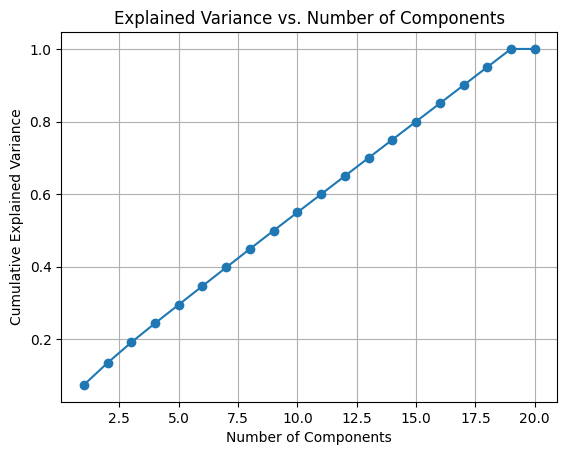

In [ ]:
# GWR PCA Test

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load new datasets
print("Loading new datasets...")
train_data = pd.read_csv("../../Data/normalized_train.csv")
test_data = pd.read_csv("../../Data/normalized_test.csv")

# Define target variable and features
print("Defining target variable and features...")
target_variable = "resale_price"
model_columns = [  # No changes here
    "month", "year", 
    "town_YISHUN", "town_WOODLANDS", "town_TOA PAYOH", "town_TAMPINES", "town_SERANGOON", "town_SENGKANG", "town_SEMBAWANG", "town_QUEENSTOWN", "town_PUNGGOL", "town_PASIR RIS", 
    "town_MARINE PARADE", "town_KALLANG/WHAMPOA", "town_JURONG WEST", "town_JURONG EAST", "town_HOUGANG", "town_GEYLANG", "town_CLEMENTI", "town_CHOA CHU KANG", "town_CENTRAL AREA", 
    "town_BUKIT TIMAH", "town_BUKIT PANJANG", "town_BUKIT MERAH", "town_BUKIT BATOK", "town_BISHAN", "town_BEDOK", 
    "flat_type_MULTI-GENERATION", "flat_type_EXECUTIVE", "flat_type_5 ROOM", "flat_type_4 ROOM", "flat_type_3 ROOM", "flat_type_2 ROOM", 
    "storey_range_LE", 
    "price_per_sqm", 
    "flat_model_Type S2", "flat_model_Type S1", "flat_model_Terrace", "flat_model_Standard", "flat_model_Simplified", "flat_model_Premium Maisonette", "flat_model_Premium Apartment Loft", 
    "flat_model_Premium Apartment", "flat_model_New Generation", "flat_model_Multi Generation", "flat_model_Model A2", "flat_model_Model A-Maisonette", "flat_model_Model A", 
    "flat_model_Maisonette", "flat_model_Improved-Maisonette", "flat_model_Improved", "flat_model_DBSS", "flat_model_Apartment", "flat_model_Adjoined flat", "flat_model_3Gen", 
    "lease_commence_date",
    "Latitude", "Longitude", 
    "LTAMRTStation_within_1km",
    "MallCoordinates_within_1km", "Hawker_within_1km", 
    "PreSchool_within_1km", "Primary_within_1km", "Secondary_within_1km", 
    "JuniorCollege_within_1km","MixedLevel_within_1km", 
    "NParks_within_1km", "Sports_within_1km", 
]

# Convert boolean columns to integers (0 or 1)
print("Converting boolean columns to integers...")
bool_cols = train_data.select_dtypes(include=['bool']).columns
train_data[bool_cols] = train_data[bool_cols].astype(int)
test_data[bool_cols] = test_data[bool_cols].astype(int)

# Remove NaNs/Infs from dataset to prevent errors
print("Ensuring all features are numeric and removing NaNs/Infs...")
train_data[model_columns] = train_data[model_columns].apply(pd.to_numeric, errors='coerce')
test_data[model_columns] = test_data[model_columns].apply(pd.to_numeric, errors='coerce')
train_data[target_variable] = pd.to_numeric(train_data[target_variable], errors='coerce')
test_data[target_variable] = pd.to_numeric(test_data[target_variable], errors='coerce')

# Drop rows with NaNs/Infs
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()
test_data = test_data.replace([np.inf, -np.inf], np.nan).dropna()

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Extract feature matrix and coordinates
X_train = train_data[model_columns].values
X_test = test_data[model_columns].values
coords_train = train_data[['Longitude', 'Latitude']].values
coords_test = test_data[['Longitude', 'Latitude']].values

# Standardise features before PCA
print("Standardising data before PCA...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Standardise coordinates to avoid scale mismatch
coords_train = StandardScaler().fit_transform(coords_train)
coords_test = StandardScaler().fit_transform(coords_test)

pca_full = PCA().fit(X_train)
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()

# # Apply PCA
# pca = PCA(n_components=0.90)  
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

In [120]:
import numpy as np
import pandas as pd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from itertools import product

# Load new datasets
print("Loading new datasets...")
train_data = pd.read_csv("../../Data/normalized_test.csv")
test_data = pd.read_csv("../../Data/normalized_train.csv")

# Define target variable and features
print("Defining target variable and features...")
target_variable = "resale_price"
model_columns = [
    "month", "year", 
    "town_YISHUN", "town_WOODLANDS", "town_TOA PAYOH", "town_TAMPINES", "town_SERANGOON", "town_SENGKANG", "town_SEMBAWANG", "town_QUEENSTOWN", "town_PUNGGOL", "town_PASIR RIS", 
    "town_MARINE PARADE", "town_KALLANG/WHAMPOA", "town_JURONG WEST", "town_JURONG EAST", "town_HOUGANG", "town_GEYLANG", "town_CLEMENTI", "town_CHOA CHU KANG", "town_CENTRAL AREA", 
    "town_BUKIT TIMAH", "town_BUKIT PANJANG", "town_BUKIT MERAH", "town_BUKIT BATOK", "town_BISHAN", "town_BEDOK", 
    "flat_type_MULTI-GENERATION", "flat_type_EXECUTIVE", "flat_type_5 ROOM", "flat_type_4 ROOM", "flat_type_3 ROOM", "flat_type_2 ROOM", 
    "storey_range_LE", 
    "price_per_sqm", 
    "flat_model_Type S2", "flat_model_Type S1", "flat_model_Terrace", "flat_model_Standard", "flat_model_Simplified", "flat_model_Premium Maisonette", "flat_model_Premium Apartment Loft", 
    "flat_model_Premium Apartment", "flat_model_New Generation", "flat_model_Multi Generation", "flat_model_Model A2", "flat_model_Model A-Maisonette", "flat_model_Model A", 
    "flat_model_Maisonette", "flat_model_Improved-Maisonette", "flat_model_Improved", "flat_model_DBSS", "flat_model_Apartment", "flat_model_Adjoined flat", "flat_model_3Gen", 
    "lease_commence_date",
    "Latitude", "Longitude", 
    "LTAMRTStation_within_1km",
    "MallCoordinates_within_1km", "Hawker_within_1km", 
    "PreSchool_within_1km", "Primary_within_1km", "Secondary_within_1km", 
    "JuniorCollege_within_1km","MixedLevel_within_1km", 
    "NParks_within_1km", "Sports_within_1km", 
]

# Convert boolean columns to integers (0 or 1)
print("Converting boolean columns to integers...")
bool_cols = train_data.select_dtypes(include=['bool']).columns
train_data[bool_cols] = train_data[bool_cols].astype(int)
test_data[bool_cols] = test_data[bool_cols].astype(int)

# Convert all features and target variable to numeric
print("Ensuring all features are numeric...")
train_data[model_columns] = train_data[model_columns].apply(pd.to_numeric, errors='coerce')
test_data[model_columns] = test_data[model_columns].apply(pd.to_numeric, errors='coerce')
train_data[target_variable] = pd.to_numeric(train_data[target_variable], errors='coerce')
test_data[target_variable] = pd.to_numeric(test_data[target_variable], errors='coerce')

# Extract feature matrix and coordinates
X_train = train_data[model_columns].values
X_test = test_data[model_columns].values
coords_train = train_data[['Longitude', 'Latitude']].values
coords_test = test_data[['Longitude', 'Latitude']].values

# Define PCA variance thresholds and sample sizes to test
pca_variance_options = [0.95, 0.97, 0.99]
sample_sizes = [8000, 9000, 10000]

# Store results
results = []

for pca_variance, sample_size in product(pca_variance_options, sample_sizes):
    print(f"Testing PCA Variance = {pca_variance}, Sample Size = {sample_size}")

    # Apply PCA for Dimensionality Reduction
    print("Applying PCA to reduce feature dimensions...")
    pca = PCA(n_components=pca_variance)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    num_components = X_train_pca.shape[1]
    explained_variance = sum(pca.explained_variance_ratio_)

    print(f"Number of Principal Components Selected: {num_components}")
    print(f"Explained Variance: {explained_variance:.2f}")

    # Select optimal bandwidth using cross-validation
    print("Selecting optimal bandwidth using cross-validation...")
    try:
        # Randomly select sample_size rows for bandwidth selection
        sample_indices = np.random.choice(len(train_data), sample_size, replace=False)

        selector = Sel_BW(
            coords_train[sample_indices], 
            train_data[target_variable].values[sample_indices].reshape(-1, 1), 
            X_train_pca[sample_indices]
        )

        optimal_bandwidth = selector.search()
        print(f"Optimal Bandwidth: {optimal_bandwidth}")

        # Store results
        results.append({
            "PCA Variance": pca_variance,
            "Sample Size": sample_size,
            "Num Components": num_components,
            "Explained Variance": explained_variance,
            "Optimal Bandwidth": optimal_bandwidth
        })

    except np.linalg.LinAlgError:
        print("❌ ERROR: Matrix is still singular after preprocessing.")
        results.append({
            "PCA Variance": pca_variance,
            "Sample Size": sample_size,
            "Num Components": num_components,
            "Explained Variance": explained_variance,
            "Optimal Bandwidth": "Singular Matrix Error"
        })

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("gwr_pca_bandwidth_experiment.csv", index=False)
print("✅ Experimentation results saved to gwr_pca_bandwidth_experiment.csv")


Loading new datasets...
Defining target variable and features...
Converting boolean columns to integers...
Ensuring all features are numeric...
Testing PCA Variance = 0.95, Sample Size = 8000
Applying PCA to reduce feature dimensions...
Number of Principal Components Selected: 6
Explained Variance: 0.96
Selecting optimal bandwidth using cross-validation...
Optimal Bandwidth: 56.0
Testing PCA Variance = 0.95, Sample Size = 9000
Applying PCA to reduce feature dimensions...
Number of Principal Components Selected: 6
Explained Variance: 0.96
Selecting optimal bandwidth using cross-validation...
❌ ERROR: Matrix is still singular after preprocessing.
Testing PCA Variance = 0.95, Sample Size = 10000
Applying PCA to reduce feature dimensions...
Number of Principal Components Selected: 6
Explained Variance: 0.96
Selecting optimal bandwidth using cross-validation...


KeyboardInterrupt: 

In [ ]:
# GWR PCA - Fixed for Numerical Stability Issues

import numpy as np
import pandas as pd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load new datasets
print("Loading new datasets...")
train_data = pd.read_csv("../../Data/normalized_train.csv")
test_data = pd.read_csv("../../Data/normalized_test.csv")

# Define target variable and features
print("Defining target variable and features...")
target_variable = "resale_price"
model_columns = [  # No changes here
    "month", "year", 
    "town_YISHUN", "town_WOODLANDS", "town_TOA PAYOH", "town_TAMPINES", "town_SERANGOON", "town_SENGKANG", "town_SEMBAWANG", "town_QUEENSTOWN", "town_PUNGGOL", "town_PASIR RIS", 
    "town_MARINE PARADE", "town_KALLANG/WHAMPOA", "town_JURONG WEST", "town_JURONG EAST", "town_HOUGANG", "town_GEYLANG", "town_CLEMENTI", "town_CHOA CHU KANG", "town_CENTRAL AREA", 
    "town_BUKIT TIMAH", "town_BUKIT PANJANG", "town_BUKIT MERAH", "town_BUKIT BATOK", "town_BISHAN", "town_BEDOK", 
    "flat_type_MULTI-GENERATION", "flat_type_EXECUTIVE", "flat_type_5 ROOM", "flat_type_4 ROOM", "flat_type_3 ROOM", "flat_type_2 ROOM", 
    "storey_range_LE", 
    "price_per_sqm", 
    "flat_model_Type S2", "flat_model_Type S1", "flat_model_Terrace", "flat_model_Standard", "flat_model_Simplified", "flat_model_Premium Maisonette", "flat_model_Premium Apartment Loft", 
    "flat_model_Premium Apartment", "flat_model_New Generation", "flat_model_Multi Generation", "flat_model_Model A2", "flat_model_Model A-Maisonette", "flat_model_Model A", 
    "flat_model_Maisonette", "flat_model_Improved-Maisonette", "flat_model_Improved", "flat_model_DBSS", "flat_model_Apartment", "flat_model_Adjoined flat", "flat_model_3Gen", 
    "lease_commence_date",
    "Latitude", "Longitude", 
    "LTAMRTStation_within_1km",
    "MallCoordinates_within_1km", "Hawker_within_1km", 
    "PreSchool_within_1km", "Primary_within_1km", "Secondary_within_1km", 
    "JuniorCollege_within_1km","MixedLevel_within_1km", 
    "NParks_within_1km", "Sports_within_1km", 
]

# Convert boolean columns to integers (0 or 1)
print("Converting boolean columns to integers...")
bool_cols = train_data.select_dtypes(include=['bool']).columns
train_data[bool_cols] = train_data[bool_cols].astype(int)
test_data[bool_cols] = test_data[bool_cols].astype(int)

# Remove NaNs/Infs from dataset to prevent errors
print("Ensuring all features are numeric and removing NaNs/Infs...")
train_data[model_columns] = train_data[model_columns].apply(pd.to_numeric, errors='coerce')
test_data[model_columns] = test_data[model_columns].apply(pd.to_numeric, errors='coerce')
train_data[target_variable] = pd.to_numeric(train_data[target_variable], errors='coerce')
test_data[target_variable] = pd.to_numeric(test_data[target_variable], errors='coerce')

# Drop rows with NaNs/Infs
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()
test_data = test_data.replace([np.inf, -np.inf], np.nan).dropna()

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Extract feature matrix and coordinates
X_train = train_data[model_columns].values
X_test = test_data[model_columns].values
coords_train = train_data[['Longitude', 'Latitude']].values
coords_test = test_data[['Longitude', 'Latitude']].values

# Standardise features before PCA
print("Standardising data before PCA...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Standardise coordinates to avoid scale mismatch
coords_train = StandardScaler().fit_transform(coords_train)
coords_test = StandardScaler().fit_transform(coords_test)

# Apply PCA
pca = PCA(n_components=0.85)  
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Number of Principal Components Selected: {X_train_pca.shape[1]}")
print(f"Explained Variance: {sum(pca.explained_variance_ratio_):.2f}")

kernel = 'gaussian'
adaptive = False

try:
    print("Selecting optimal bandwidth using cross-validation...")
    sample_indices = np.random.choice(len(train_data), 5000, replace=False)

    selector = Sel_BW(
        coords_train[sample_indices], 
        train_data[target_variable].values[sample_indices].reshape(-1, 1), 
        X_train_pca[sample_indices],
        kernel=kernel, 
        fixed=not adaptive
    )
    
    opt_bw = selector.search()

    # Ensure bandwidth is within reasonable limits
    if np.isnan(opt_bw) or np.isinf(opt_bw) or opt_bw <= 0:
        raise ValueError("Optimal bandwidth (opt_bw) is invalid!")

    print(f"Optimal Bandwidth: {opt_bw}")

    print("Verifying input shapes before GWR...")
    print(f"coords_train shape: {coords_train.shape}")
    print(f"Target variable shape: {train_data[target_variable].values.reshape(-1, 1).shape}")
    print(f"X_train_pca shape: {X_train_pca.shape}")
    print(f"opt_bw: {opt_bw}")

    # Train the GWR model
    print("Training the GWR model...")
    gwr_model = GWR(
        coords_train, 
        train_data[target_variable].values.reshape(-1, 1), 
        X_train_pca, 
        bw=opt_bw, 
        kernel=kernel, 
        fixed=not adaptive
    )
    gwr_results = gwr_model.fit()
    print("GWR Model Fitted Successfully!")
    gwr_results.summary()

    # Generate predictions
    scale = gwr_results.scale
    residuals = gwr_results.resid_response
    print(f"Scale: {scale}")
    print(f"Residuals Shape: {residuals.shape}")

    y_pred = gwr_model.predict(coords_test, X_test_pca, scale, residuals)

    # Evaluate performance
    mae = mean_absolute_error(test_data[target_variable], y_pred.predictions.flatten())
    mse = mean_squared_error(test_data[target_variable], y_pred.predictions.flatten())
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data[target_variable], y_pred.predictions.flatten())
    mape = np.mean(np.abs((test_data[target_variable] - y_pred.predictions.flatten()) / test_data[target_variable])) * 100

    print(f"MAE: {mae}, MAPE: {mape}, MSE: {mse}, RMSE: {rmse}, R² Score: {r2}")

except Exception as e:
    print(f"Error: {str(e)}")


Loading new datasets...
Defining target variable and features...
Converting boolean columns to integers...
Ensuring all features are numeric and removing NaNs/Infs...
Standardising data before PCA...
Number of Principal Components Selected: 42
Explained Variance: 0.86
Selecting optimal bandwidth using cross-validation...
Optimal Bandwidth: 0.03
Verifying input shapes before GWR...
coords_train shape: (339629, 2)
Target variable shape: (339629, 1)
X_train_pca shape: (339629, 42)
opt_bw: 0.03
Training the GWR model...


In [26]:
import numpy as np

# Function to check NaNs and Infs in arrays
def check_nans_infs(name, array):
    if np.any(np.isnan(array)):
        print(f"Warning: {name} contains NaNs!")
    if np.any(np.isinf(array)):
        print(f"Warning: {name} contains Infs!")

# Checking coords_train (longitude & latitude)
print("Checking coords_train...")
check_nans_infs("coords_train", coords_train)

# Checking target variable
print("Checking target variable (resale_price)...")
check_nans_infs("train_data[target_variable]", train_data[target_variable].values.reshape(-1, 1))

# Checking X_train_pca (PCA-transformed features)
print("Checking X_train_pca...")
check_nans_infs("X_train_pca", X_train_pca)

# Checking bandwidth selection value
if np.isnan(opt_bw) or np.isinf(opt_bw):
    print("Warning: opt_bw contains NaN or Inf!")

print("----------------------------------------")

print("Checking for extreme values in data...")

# Check coordinates
print(f"Longitude range: {coords_train[:, 0].min()} to {coords_train[:, 0].max()}")
print(f"Latitude range: {coords_train[:, 1].min()} to {coords_train[:, 1].max()}")

# Check PCA-transformed features
print(f"X_train_pca min: {X_train_pca.min()}, max: {X_train_pca.max()}")
print(f"X_test_pca min: {X_test_pca.min()}, max: {X_test_pca.max()}")

# Check target variable
print(f"Target variable min: {train_data[target_variable].min()}, max: {train_data[target_variable].max()}")



Checking coords_train...
Checking target variable (resale_price)...
Checking X_train_pca...
----------------------------------------
Checking for extreme values in data...
Longitude range: 0.0 to 0.9999335674604416
Latitude range: 0.0 to 1.0
X_train_pca min: -44.949677061239676, max: 91.05383911922348
X_test_pca min: -31.838691868628906, max: 77.15761195280511
Target variable min: 0.0068493150684931, max: 0.9863013698630138



GUASSIAN
Mean Absolute Error (MAE): 0.07886822348806316
Mean Squared Error (MSE): 0.010459145242201446
Root Mean Squared Error (RMSE): 0.10226996256086851
R² Score: 0.3386578854628215

BISQUARE
Mean Absolute Error (MAE): 0.07549681841499624
Mean Squared Error (MSE): 0.00996194775705299
Root Mean Squared Error (RMSE): 0.09980955744342819
R² Score: 0.3700961749746552

EXPONENTIAL
Mean Absolute Error (MAE): 0.07836792864710952
Mean Squared Error (MSE): 0.010350346436098199
Root Mean Squared Error (RMSE): 0.1017366523731649
R² Score: 0.34553734174927964

In [1]:
import numpy as np
import pandas as pd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from itertools import product
import dask
from dask.distributed import Client

# Initialize Dask client for parallel processing
client = Client()

# Load new datasets
print("Loading new datasets...")
train_data = pd.read_csv("../../Data/normalized_test.csv")
test_data = pd.read_csv("../../Data/normalized_train.csv")

# Define target variable and features
print("Defining target variable and features...")
target_variable = "resale_price"
model_columns = [
    "month", "year", 
    "town_YISHUN", "town_WOODLANDS", "town_TOA PAYOH", "town_TAMPINES", "town_SERANGOON", "town_SENGKANG", "town_SEMBAWANG", "town_QUEENSTOWN", "town_PUNGGOL", "town_PASIR RIS", 
    "town_MARINE PARADE", "town_KALLANG/WHAMPOA", "town_JURONG WEST", "town_JURONG EAST", "town_HOUGANG", "town_GEYLANG", "town_CLEMENTI", "town_CHOA CHU KANG", "town_CENTRAL AREA", 
    "town_BUKIT TIMAH", "town_BUKIT PANJANG", "town_BUKIT MERAH", "town_BUKIT BATOK", "town_BISHAN", "town_BEDOK", 
    "flat_type_MULTI-GENERATION", "flat_type_EXECUTIVE", "flat_type_5 ROOM", "flat_type_4 ROOM", "flat_type_3 ROOM", "flat_type_2 ROOM", 
    "storey_range_LE", 
    "price_per_sqm", 
    "flat_model_Type S2", "flat_model_Type S1", "flat_model_Terrace", "flat_model_Standard", "flat_model_Simplified", "flat_model_Premium Maisonette", "flat_model_Premium Apartment Loft", 
    "flat_model_Premium Apartment", "flat_model_New Generation", "flat_model_Multi Generation", "flat_model_Model A2", "flat_model_Model A-Maisonette", "flat_model_Model A", 
    "flat_model_Maisonette", "flat_model_Improved-Maisonette", "flat_model_Improved", "flat_model_DBSS", "flat_model_Apartment", "flat_model_Adjoined flat", "flat_model_3Gen", 
    "lease_commence_date",
    "Latitude", "Longitude", 
    "LTAMRTStation_within_1km",
    "MallCoordinates_within_1km", "Hawker_within_1km", 
    "PreSchool_within_1km", "Primary_within_1km", "Secondary_within_1km", 
    "JuniorCollege_within_1km","MixedLevel_within_1km", 
    "NParks_within_1km", "Sports_within_1km", 
]

# Convert boolean columns to integers (0 or 1)
print("Converting boolean columns to integers...")
bool_cols = train_data.select_dtypes(include=['bool']).columns
train_data[bool_cols] = train_data[bool_cols].astype(int)
test_data[bool_cols] = test_data[bool_cols].astype(int)

# Convert all features and target variable to numeric
print("Ensuring all features are numeric...")
train_data[model_columns] = train_data[model_columns].apply(pd.to_numeric, errors='coerce')
test_data[model_columns] = test_data[model_columns].apply(pd.to_numeric, errors='coerce')
train_data[target_variable] = pd.to_numeric(train_data[target_variable], errors='coerce')
test_data[target_variable] = pd.to_numeric(test_data[target_variable], errors='coerce')

# Extract feature matrix and coordinates
X_train = train_data[model_columns].values
X_test = test_data[model_columns].values
coords_train = train_data[['Longitude', 'Latitude']].values
coords_test = test_data[['Longitude', 'Latitude']].values

# Apply PCA to retain 97% variance
print("Applying PCA for 0.97 variance...")
pca = PCA(n_components=0.97)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Number of Principal Components Selected: {X_train_pca.shape[1]}")
print(f"Explained Variance: {sum(pca.explained_variance_ratio_):.2f}")


# kernels = ['gaussian', 'bisquare', 'exponential']
# adaptive_options = [True, False]

# Define hyperparameter grid
kernels = ['gaussian']
adaptive_options = [False]

print("Traning and Evaluation...")
# Function to train and evaluate a GWR model
@dask.delayed
def train_gwr(kernel, adaptive):
    print(f"Testing kernel: {kernel}, Adaptive: {adaptive}", flush=True)
    try:
        # selector = Sel_BW(coords_train, train_data[target_variable].values.reshape(-1, 1), X_train_pca, kernel=kernel, fixed=not adaptive)
        
        # Randomly select sample_size rows for bandwidth selection
        sample_indices = np.random.choice(len(train_data), 5000, replace=False)

        selector = Sel_BW(
            coords_train[sample_indices], 
            train_data[target_variable].values[sample_indices].reshape(-1, 1), 
            X_train_pca[sample_indices],
            kernel=kernel, 
            fixed=not adaptive
        )
        
        opt_bw = selector.search()
        
        print("Fitting the GWR model...", flush=True)
        gwr_model = GWR(coords_train, train_data[target_variable].values.reshape(-1, 1), X_train_pca, bw=opt_bw, kernel=kernel, fixed=not adaptive)
        gwr_results = gwr_model.fit()
        print("GWR Model Fitted Successfully!", flush=True)
        gwr_results.summary()
        
        # Generate predictions correctly
        scale = gwr_results.scale
        residuals = gwr_results.resid_response
        y_pred = gwr_model.predict(coords_test, X_test_pca, scale, residuals)
        
        mae = mean_absolute_error(test_data[target_variable], y_pred.predictions.flatten())
        mse = mean_squared_error(test_data[target_variable], y_pred.predictions.flatten())
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data[target_variable], y_pred.predictions.flatten())
        mape = np.mean(np.abs((test_data[target_variable] - y_pred.predictions.flatten()) / test_data[target_variable])) * 100
        aic = gwr_results.aic
    except Exception as e:
        print(f"Error occurred with kernel: {kernel}, Adaptive: {adaptive}: {str(e)}", flush=True)
        opt_bw, mae, mse, rmse, r2, mape, aic = -1, -1, -1, -1, -1, -1, -1
    
    return {
        "Kernel": kernel,
        "Adaptive": adaptive,
        "Bandwidth": opt_bw,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2,
        "MAPE": mape,
        "AIC": aic
    }

# Parallel grid search using Dask
results = dask.compute(*[train_gwr(kernel, adaptive) for kernel, adaptive in product(kernels, adaptive_options)])

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("gwr_results_1.csv", index=False)

# Identify best model based on AIC
best_result = min(results, key=lambda x: x["AIC"])
print(f"Best Kernel: {best_result['Kernel']}, Adaptive: {best_result['Adaptive']}, Optimal Bandwidth: {best_result['Bandwidth']}")
print(f"Best AIC Score: {best_result['AIC']}")

# Shutdown the Dask client to free resources
client.shutdown()

Loading new datasets...
Defining target variable and features...
Converting boolean columns to integers...
Ensuring all features are numeric...
Applying PCA for 0.97 variance...
Number of Principal Components Selected: 7
Explained Variance: 0.98
Traning and Evaluation...


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 234.50 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-03-12 21:27:24,786 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62905 (pid=26208) exceeded 95% memory budget. Restarting...
2025-03-12 21:27:25,218 - distributed.nanny - WARNING - Restarting worker
2025-03-12 21:37:53,251 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62911 (pid=9172) exceeded 95% memory budget. Restarting...
2025-03-12 21:37:53,687 - distributed.nanny - WARNING - Restarting worker
2025-03-12 21:48:12,291 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62994 (pid=2744) exceeded 95% memory

KilledWorker: Attempted to run task 'train_gwr-feb4f99e-4787-4d0f-b764-e5f7a2b31f2b' on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:62906. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.